In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
import pandas as pd

In [2]:
columns = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

df_full = pd.read_csv('data.csv', usecols=columns)  # use only columns specified
df_full.columns = df_full.columns.str.replace(' ', '_').str.lower()  # lowercase column names and replace spaces with underscores
df_full = df_full.fillna(0)  # fill missing values with 0

# make price binary
price_avg = df_full['msrp'].mean()
df_full['above_average'] = (df_full['msrp'] > price_avg).astype(int)

del df_full['msrp']

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   above_average      11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [3]:
# split data
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df_full, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y_train_full = df_train_full.above_average
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# del df_train_full['above_average']
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- **`engine_hp`**
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`


In [4]:
from sklearn.metrics import roc_auc_score

numeric_columns = df_train.select_dtypes(include='number').columns.tolist()
auc_scores = {}

for col in numeric_columns:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    auc_scores[col] = score

sorted(auc_scores.items(), key=lambda x: -x[1])

[('engine_hp', 0.9171031265539011),
 ('engine_cylinders', 0.766116490165669),
 ('year', 0.687551492804683),
 ('city_mpg', 0.6734244643245233),
 ('highway_mpg', 0.6330587871772013)]

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- **0.979**

In [5]:
# OHE
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.979

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* **0.48**
* 0.68
* 0.88

In [7]:
import numpy as np

thresholds = np.arange(0, 1, 0.01)
scores = []
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

for t in thresholds:
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred < t)

    tp = (pred_pos & actual_pos).sum()
    tn = (pred_neg & actual_neg).sum()
    fp = (pred_pos & actual_neg).sum()
    fn = (pred_neg & actual_pos).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, precision, recall))

In [8]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])

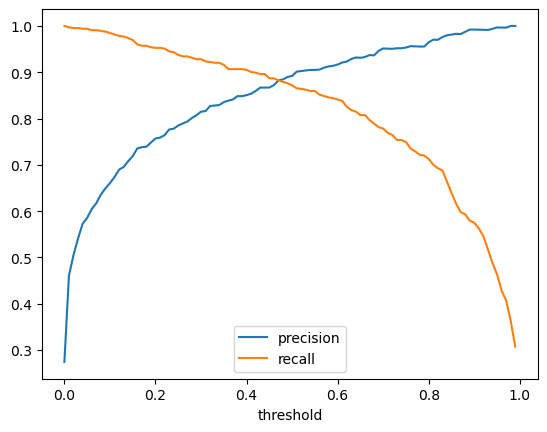

In [9]:
import matplotlib.pyplot as plt

plt.plot(df_scores['threshold'], df_scores['precision'], label='precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='recall')
plt.xlabel('threshold')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- **0.52**
- 0.72

In [10]:
thresholds = np.arange(0, 1, 0.01)
scores = []
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

for t in thresholds:
    pred_pos = (y_pred >= t)
    pred_neg = (y_pred < t)

    tp = (pred_pos & actual_pos).sum()
    tn = (pred_neg & actual_neg).sum()
    fp = (pred_pos & actual_neg).sum()
    fn = (pred_neg & actual_pos).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    scores.append((t, f1))

In [11]:
max(scores, key=lambda x: x[1])

(0.51, 0.8829953198127924)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- **0.003**
- 0.030
- 0.090
- 0.140

In [12]:
from sklearn.model_selection import KFold

In [17]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [18]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores), 3)

0.003

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

mean_scores = {}
for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        df_train = df_train.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
        
        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    mean_scores[C] = round(np.average(scores), 3)

sorted(mean_scores.items(), key=lambda x: -x[1])

[(10, 0.981), (0.5, 0.977), (0.1, 0.972), (0.01, 0.952)]